# Seed labeling with scANVI

In this tutorial, we go through the steps of training scANVI for seed annotation. This is useful for when we have ground truth labels for a few cells and want to annotate unlabelled cells. For more information, please refer to the original [scANVI publication](https://www.biorxiv.org/content/biorxiv/early/2019/01/29/532895.full.pdf).

Plan for this tutorial:

1. Loading the data
1. Creating the seed labels: groundtruth for a small fraction of cells
1. Training the scANVI model: transferring annotation to the whole dataset
1. Visualizing the latent space and predicted labels

```{note}
Running the following cell will install tutorial dependencies on Google Colab only. It will have no effect on environments other than Google Colab.
```

In [1]:
!pip install --quiet scvi-colab
from scvi_colab import install

install()

INFO     scvi-colab: Installing scvi-tools.                                                                        
INFO     scvi-colab: Install successful. Testing import.                                                           


/usr/local/lib/python3.12/dist-packages/pyro/ops/stats.py:527: SyntaxWarning: invalid escape sequence '\g'
  we have :math:`ES^{*}(P,Q) \ge ES^{*}(Q,Q)` with equality holding if and only if :math:`P=Q`, i.e.


In [2]:
import tempfile

import numpy as np
import scanpy as sc
import scvi
import seaborn as sns
import torch

/usr/local/lib/python3.12/dist-packages/leidenalg/VertexPartition.py:413: SyntaxWarning: invalid escape sequence '\m'
  .. math:: Q = \\frac{1}{m} \\sum_{ij} \\left(A_{ij} - \\frac{k_i^\mathrm{out} k_j^\mathrm{in}}{m} \\right)\\delta(\\sigma_i, \\sigma_j),
/usr/local/lib/python3.12/dist-packages/leidenalg/VertexPartition.py:788: SyntaxWarning: invalid escape sequence '\m'
  .. math:: Q = \\sum_{ij} \\left(A_{ij} - \\gamma \\frac{k_i^\mathrm{out} k_j^\mathrm{in}}{m} \\right)\\delta(\\sigma_i, \\sigma_j),
/usr/local/lib/python3.12/dist-packages/leidenalg/Optimiser.py:27: SyntaxWarning: invalid escape sequence '\g'
  implementation therefore does not guarantee subpartition :math:`\gamma`-density.
/usr/local/lib/python3.12/dist-packages/leidenalg/Optimiser.py:346: SyntaxWarning: invalid escape sequence '\s'
  .. math:: Q = \sum_k \\lambda_k Q_k.


In [3]:
scvi.settings.seed = 0
print("Last run with scvi-tools version:", scvi.__version__)

INFO: Seed set to 0
INFO:lightning.fabric.utilities.seed:Seed set to 0


Last run with scvi-tools version: 1.4.0


```{note}
You can modify `save_dir` below to change where the data files for this tutorial are saved.
```

In [4]:
sc.set_figure_params(figsize=(6, 6), frameon=False)
sns.set_theme()
torch.set_float32_matmul_precision("high")
save_dir = tempfile.TemporaryDirectory()

%config InlineBackend.print_figure_kwargs={"facecolor": "w"}
%config InlineBackend.figure_format="retina"

## Data Loading

For the purposes of this notebook, we will be labeling 4 cell types in a dataset of purified peripheral blood mononuclear cells from 10x Genomics:

- CD4 Regulatory T cells
- CD4 Naive T cells
- CD4 Memory T cells
- CD8 Naive T cells

In [5]:
adata = scvi.data.purified_pbmc_dataset(
    save_path=save_dir.name,
    subset_datasets=["regulatory_t", "naive_t", "memory_t", "naive_cytotoxic"],
)

INFO     Downloading file at /tmp/tmpdsrvoml7/PurifiedPBMCDataset.h5ad                                             


Downloading...:   0%|          | 0/157053.0 [00:00<?, ?it/s]

From now on, we assume that cell type information for each cell is unavailable to us, and we seek to retrieve it.

## Automatic annotation using seed labels

In this section we hand curate and select cells which will serve as our ground truth labels.

We start by putting together a list of curated marker genes, from which we aim at identifying our ground truth cell types. These are extracted from the scANVI publication.

In [6]:
gene_subset = [
    "CD4",
    "FOXP3",
    "TNFRSF18",
    "IL2RA",
    "CTLA4",
    "CD44",
    "TCF7",
    "CD8B",
    "CCR7",
    "CD69",
    "PTPRC",
    "S100A4",
]

Then, we assign a score to every cell as a function of its cell type signature. In order to compute these scores, we need to normalize the data. Because this is not the case of scVI or scANVI, we proceed with a copy of the dataset for this step.

In [7]:
normalized = adata.copy()
sc.pp.normalize_total(normalized, target_sum=1e4)
sc.pp.log1p(normalized)

normalized = normalized[:, gene_subset].copy()
sc.pp.scale(normalized)

/usr/lib/python3.12/functools.py:912: UserWarning: zero-centering a sparse array/matrix densifies it.
  return dispatch(args[0].__class__)(*args, **kw)


Now, here we have two helper functions that will help in scoring the cells, as well as taking the most confident cells with respect to these scores.

In [8]:
def get_score(normalized_adata, gene_set):
    """Returns the score per cell given a dictionary of + and - genes.

    Parameters
    ----------
    normalized_adata
      anndata dataset that has been log normalized and scaled to mean 0, std 1
    gene_set
      a dictionary with two keys: 'positive' and 'negative'
      each key should contain a list of genes
      for each gene in gene_set['positive'], its expression will be added to the score
      for each gene in gene_set['negative'], its expression will be subtracted from its score

    Returns
    -------
    array of length of n_cells containing the score per cell
    """
    score = np.zeros(normalized_adata.n_obs)
    for gene in gene_set["positive"]:
        expression = np.array(normalized_adata[:, gene].X)
        score += expression.flatten()
    for gene in gene_set["negative"]:
        expression = np.array(normalized_adata[:, gene].X)
        score -= expression.flatten()
    return score


def get_cell_mask(normalized_adata, gene_set):
    """Get cell mask.

    Calculates the score per cell for a list of genes, then returns a mask for
    the cells with the highest 50 scores.

    Parameters
    ----------
    normalized_adata
      anndata dataset that has been log normalized and scaled to mean 0, std 1
    gene_set
      a dictionary with two keys: 'positive' and 'negative'
      each key should contain a list of genes
      for each gene in gene_set['positive'], its expression will be added to the score
      for each gene in gene_set['negative'], its expression will be subtracted from its score

    Returns
    -------
    Mask for the cells with the top 50 scores over the entire dataset
    """
    score = get_score(normalized_adata, gene_set)
    cell_idx = score.argsort()[-50:]
    mask = np.zeros(normalized_adata.n_obs)
    mask[cell_idx] = 1
    return mask.astype(bool)

We run those function to identify highly confident cells, that we aim at using as seed labels

In [9]:
# hand curated list of genes for identifying ground truth


cd4_reg_geneset = {
    "positive": ["TNFRSF18", "CTLA4", "FOXP3", "IL2RA"],
    "negative": ["S100A4", "PTPRC", "CD8B"],
}

cd8_naive_geneset = {"positive": ["CD8B", "CCR7"], "negative": ["CD4"]}

cd4_naive_geneset = {
    "positive": ["CCR7", "CD4"],
    "negative": ["S100A4", "PTPRC", "FOXP3", "IL2RA", "CD69"],
}

cd4_mem_geneset = {
    "positive": ["S100A4"],
    "negative": ["IL2RA", "FOXP3", "TNFRSF18", "CCR7"],
}

In [10]:
cd4_reg_mask = get_cell_mask(
    normalized,
    cd4_reg_geneset,
)
cd8_naive_mask = get_cell_mask(
    normalized,
    cd8_naive_geneset,
)
cd4_naive_mask = get_cell_mask(
    normalized,
    cd4_naive_geneset,
)
cd4_mem_mask = get_cell_mask(
    normalized,
    cd4_mem_geneset,
)

In [11]:
seed_labels = np.array(cd4_mem_mask.shape[0] * ["Unknown"])
seed_labels[cd8_naive_mask] = "CD8 Naive T cell"
seed_labels[cd4_naive_mask] = "CD4 Naive T cell"
seed_labels[cd4_mem_mask] = "CD4 Memory T cell"
seed_labels[cd4_reg_mask] = "CD4 Regulatory T cell"

adata.obs["seed_labels"] = seed_labels

We can observe what seed label information we have now

In [12]:
adata.obs.seed_labels.value_counts()

,count
seed_labels,
Unknown,42719
CD4 Reg,50
CD4 Nai,50
CD4 Mem,50
CD8 Nai,50


As expected, we use 50 cells for each cell type!

### Transfer of annotation with scANVI

As in the harmonization notebook, we need to register the AnnData object for use in scANVI. Namely, we can ignore the batch parameter because those cells don't have much batch effect to begin with. However, we will give the seed labels for scANVI to use.

In [13]:
scvi.model.SCVI.setup_anndata(adata, batch_key=None, labels_key="seed_labels")

In [14]:
scvi_model = scvi.model.SCVI(adata, n_latent=30, n_layers=2)

In [15]:
scvi_model.train(100)

INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/usr/local/lib/python3.12/dist-packages/lightning/pytorch/trainer/connectors/data_connector.py:433: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


Training:   0%|          | 0/100 [00:00<?, ?it/s]

INFO: `Trainer.fit` stopped: `max_epochs=100` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=100` reached.


Now we can train scANVI and transfer the labels!

In [16]:
scanvi_model = scvi.model.SCANVI.from_scvi_model(scvi_model, "Unknown")

In [17]:
scanvi_model.train(25)

INFO     Training for 25 epochs.                                                                                   


INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/usr/local/lib/python3.12/dist-packages/lightning/pytorch/trainer/connectors/data_connector.py:433: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


Training:   0%|          | 0/25 [00:00<?, ?it/s]

INFO: `Trainer.fit` stopped: `max_epochs=25` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=25` reached.


Now we can predict the missing cell types, and get the latent space

In [18]:
SCANVI_LATENT_KEY = "X_scANVI"
SCANVI_PREDICTIONS_KEY = "C_scANVI"

adata.obsm[SCANVI_LATENT_KEY] = scanvi_model.get_latent_representation(adata)
adata.obs[SCANVI_PREDICTIONS_KEY] = scanvi_model.predict(adata)

Again, we may visualize the latent space as well as the inferred labels

In [19]:
sc.pp.neighbors(adata, use_rep=SCANVI_LATENT_KEY)
sc.tl.umap(adata)

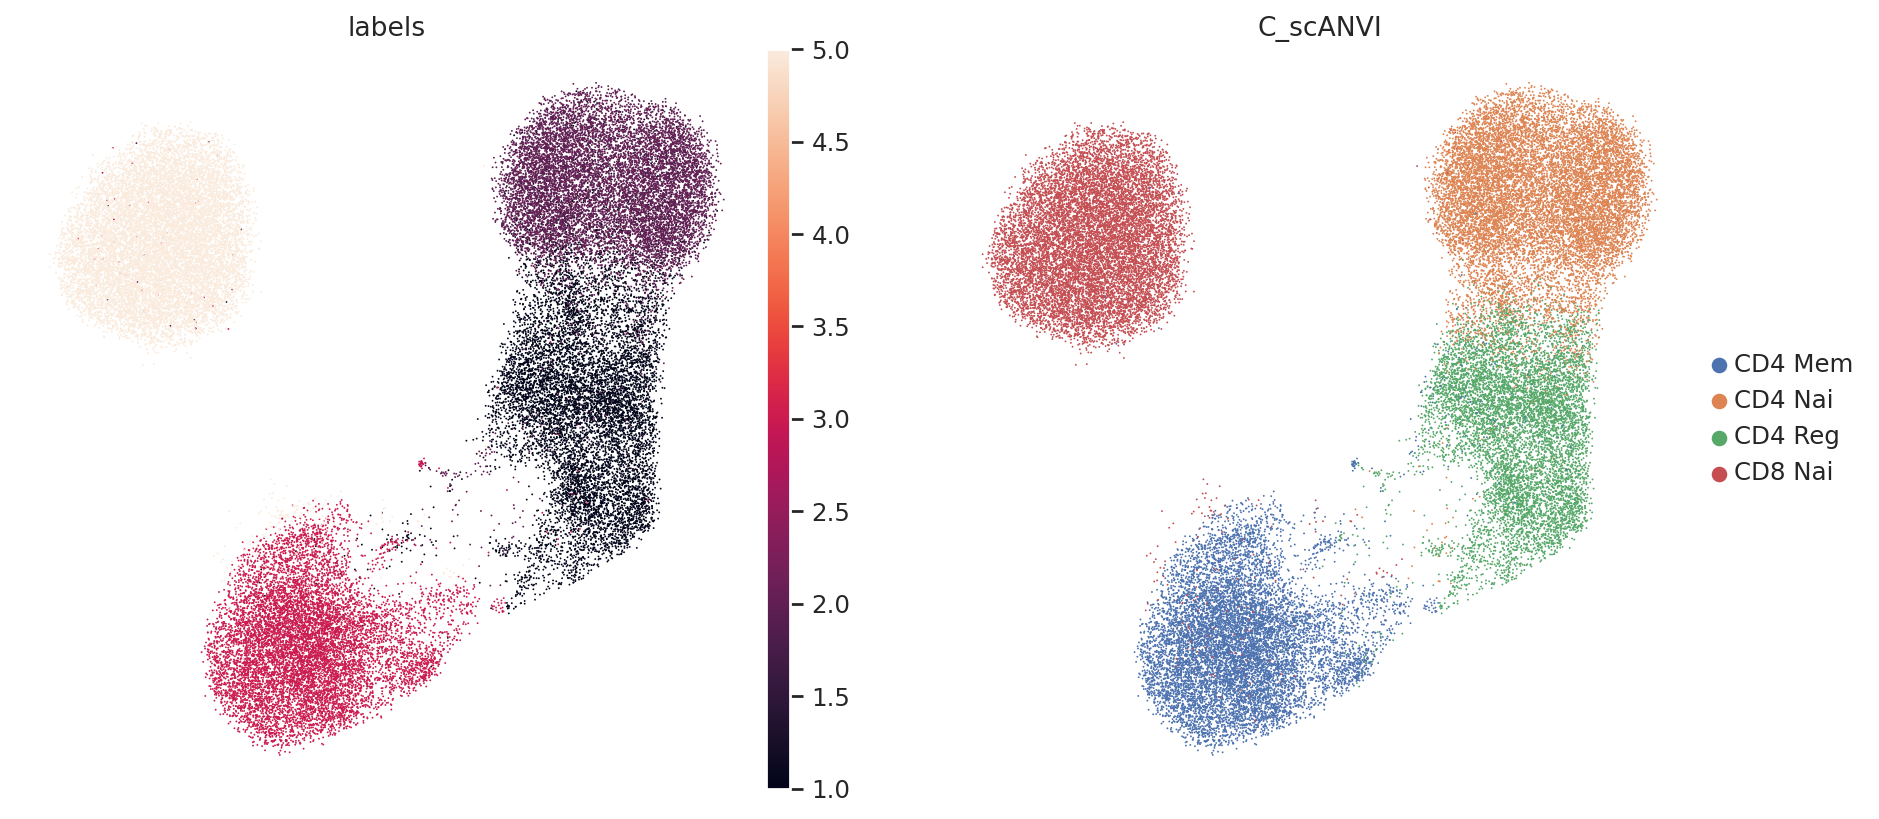

In [20]:
sc.pl.umap(adata, color=["labels", SCANVI_PREDICTIONS_KEY])

From this, we can see that it is relatively easy for scANVI to separate the CD4 T cells from the CD8 T cells (in latent space, as well as for the classifier). The regulatory CD4 T cells are sometimes missclassified into CD4 Naive, but this stays a minor phenomenon. Also, we expect that better results may be obtained by careful hyperparameter selection for the classifier. Learn about all of this in our [documentation](https://scvi.readthedocs.io/en/stable/).

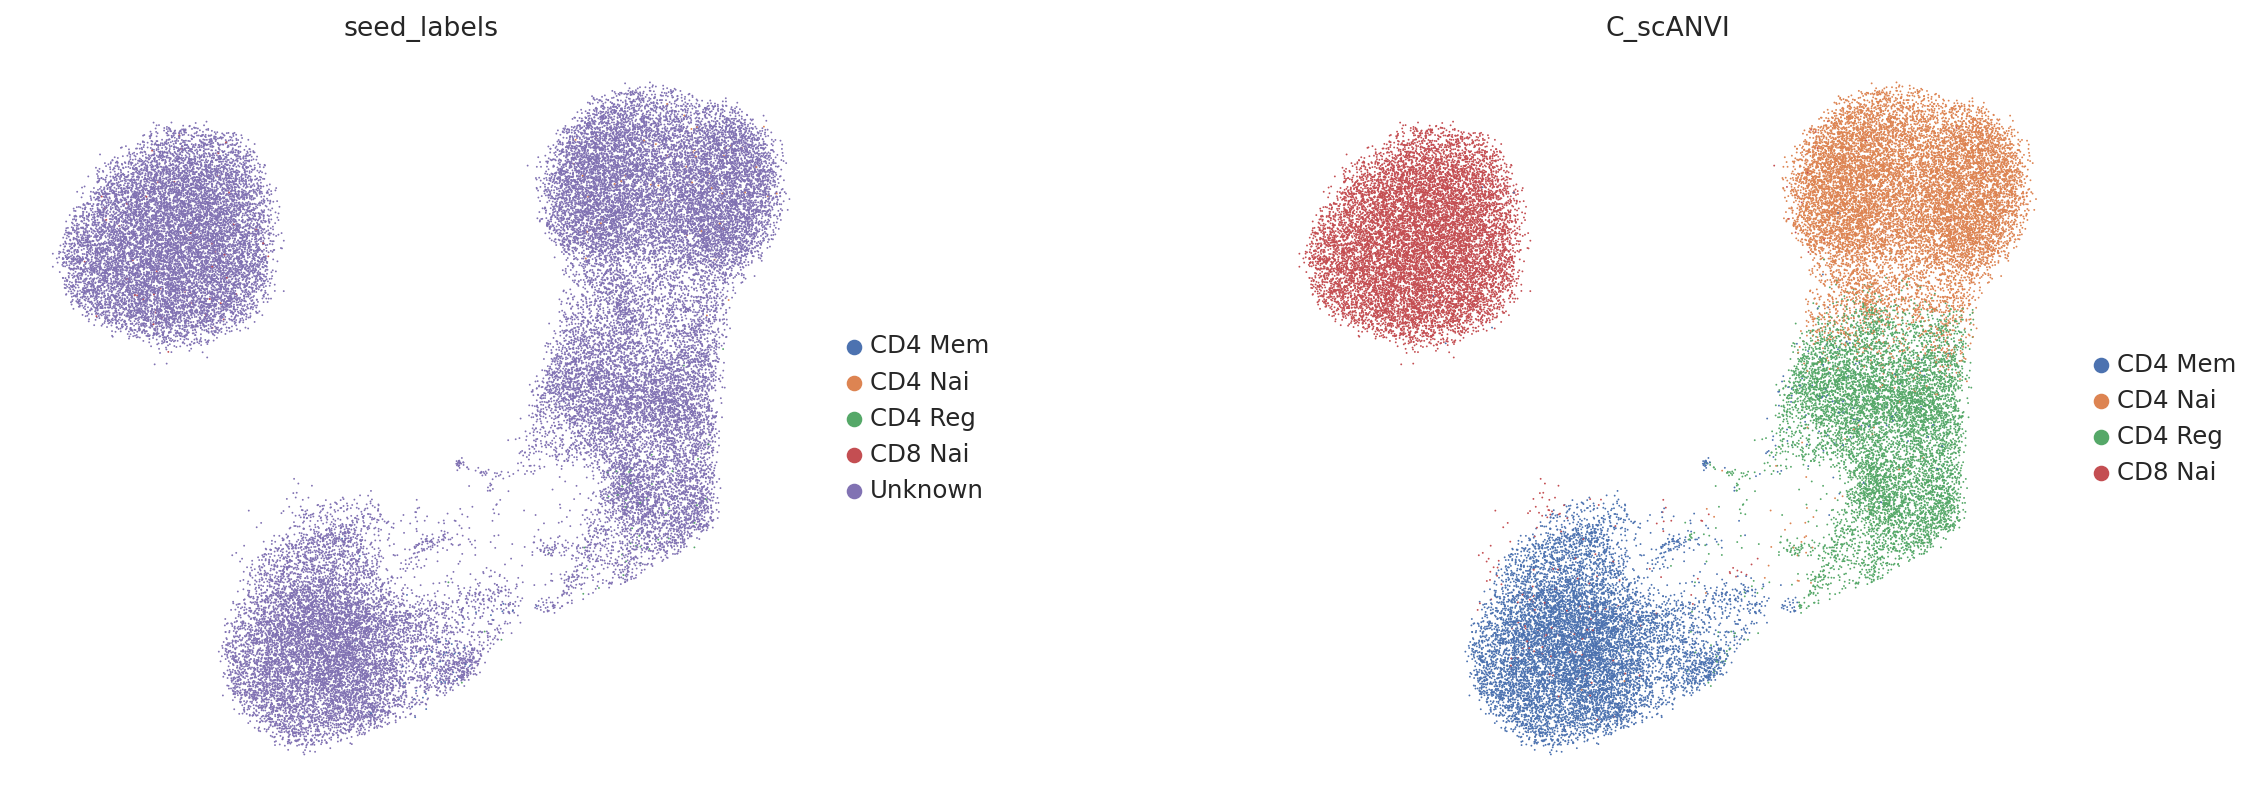

,count
seed_labels,
Unknown,42719
CD4 Mem,50
CD4 Nai,50
CD4 Reg,50
CD8 Nai,50


In [23]:
sc.pl.umap(adata, color=["seed_labels", SCANVI_PREDICTIONS_KEY], wspace=0.4)
adata.obs["seed_labels"].value_counts()
